# CL - Dynamic architectures

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one.

In this notebook, we try a method called "Dynamic architectures". For sake of simplicity, the network will have 2 output layers, one for MNIST and one for FashionMNIST. The code for a real dynamical architecture is much more complex.

In [1]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss

In [2]:
batch_size = 128
mnist_epochs = 15
fashion_epochs = 15
mnist = True
fashion = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# import MNIST
train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

mnist_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

torch.Size([60000, 28, 28])


In [5]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion/FashionMNIST/raw

torch.Size([60000, 28, 28])


In [6]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 4096)
        self.bn1 = nn.BatchNorm1d(4096)

        self.fc2 = nn.Linear(4096, 4096)
        self.bn2 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, 10)
        self.bn3 = nn.BatchNorm1d(10)

        self.fc4 = nn.Linear(4096, 10)
        self.bn4 = nn.BatchNorm1d(10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.bn1(self.fc1(x))
        x = self.bn2(self.fc2(x))
        return torch.softmax(self.bn3(self.fc3(x)), dim=1), torch.softmax(
            self.bn4(self.fc4(x)), dim=1
        )

In [7]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output, _ = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("Fashion - F1 score", score)
    return score

In [8]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long).to(device)
    y_test = torch.empty(0, dtype=torch.long).to(device)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        _, output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    score = f1_score(y_test.cpu(), y_pred.cpu(), average="macro")
    if verbose:
        print("Fashion - F1 score", score)
    return score

In [9]:
cnn = NN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []

# MNIST
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output, _ = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

--- MNIST ---
Epoch 0 - loss 1.8241840600967407
Epoch 1 - loss 1.5905842781066895
Epoch 2 - loss 1.5543403625488281
Epoch 3 - loss 1.5639888048171997
Epoch 4 - loss 1.5544085502624512
Epoch 5 - loss 1.5870195627212524
Epoch 6 - loss 1.5741347074508667
Epoch 7 - loss 1.5653313398361206
Epoch 8 - loss 1.5549006462097168
Epoch 9 - loss 1.6069782972335815
Epoch 10 - loss 1.6902847290039062
Epoch 11 - loss 1.6486517190933228
Epoch 12 - loss 1.6069836616516113
Epoch 13 - loss 1.6069831848144531
Epoch 14 - loss 1.5679893493652344
--- Scores ---
Fashion - F1 score 0.07079277519472127
Fashion - F1 score 0.886420739673702


In [10]:
# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            _, output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- FashionMNIST ---
Epoch 0 - loss 1.8787223100662231
Epoch 1 - loss 1.6470190286636353
Epoch 2 - loss 1.6292839050292969
Epoch 3 - loss 1.566257119178772
Epoch 4 - loss 1.6091166734695435
Epoch 5 - loss 1.617622971534729
Epoch 6 - loss 1.5775728225708008
Epoch 7 - loss 1.634851336479187
Epoch 8 - loss 1.5973252058029175
Epoch 9 - loss 1.5972751379013062
Epoch 10 - loss 1.5849037170410156
Epoch 11 - loss 1.5860686302185059
Epoch 12 - loss 1.6096426248550415
Epoch 13 - loss 1.6649788618087769
Epoch 14 - loss 1.604435920715332
--- Scores ---
Fashion - F1 score 0.5228602669120272
Fashion - F1 score 0.8269626538851632


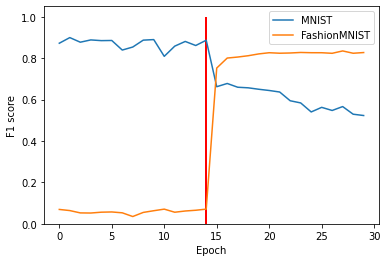

In [12]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
plt.savefig("cnn_dynamic_architecture.png")
plt.show()